## Imports

In [1]:
import lime
import lime.lime_tabular
import pandas as pd
pd.set_option('use_inf_as_na', True)
import numpy as np
from scipy.spatial import distance
from matplotlib import pyplot
from collections import Counter
from sklearn.model_selection import StratifiedKFold, KFold
from numpy import mean
from numpy import std
import xgboost as xgb
from pandas import read_csv
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, PowerTransformer, StandardScaler
from scipy.stats import normaltest
from sklearn.model_selection import ParameterSampler
from numpy.random import randn
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from numpy import *
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats.stats import pearsonr, spearmanr
from scipy import stats
import tensorflow as tf
import multiprocessing as mp
import time
from sklearn.metrics.cluster import normalized_mutual_info_score
import os
from sklearn.svm import SVR
import collections
import matplotlib.pyplot as plt
from collections import OrderedDict
import category_encoders as ce
import itertools as it
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import re
import warnings
from ngboost import NGBRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from ngboost.distns import Exponential, Normal
from scipy.stats import burr
from ngboost.scores import LogScore, CRPScore
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats.stats import pearsonr, spearmanr
import math
from scipy import stats
from scipy.spatial import distance
import warnings
from sklearn.metrics.cluster import normalized_mutual_info_score
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

## Helper Methods

In [2]:
def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    
    unique_sites = df["Site"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)
   
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, X_test, Y_train, Y_test

def get_accurate_prediction_score(y_test, y_pred):
    ratio = np.abs(y_test - y_pred) / y_test
    return ratio
           

## Data

In [3]:
columnsToDrop = ['Year', 'Climate','Day','Latitude','Longitude',
                 'G','G-1','G-2','G-3','G-4','G-5',
                 'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
                 'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
                 'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr',
                 'ET_bowen','ET_bowen_corr','ET_ebr','ET_ebr_corr',
                 'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
                 'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
                 'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
                 'Climate_2','Climate_3', 'Latitude_1', "SW_IN",
                 'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
                 'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
                 'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
                 'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'LE_ebr_corr(mm)',
                 'ET_bowen_corr_mm', 'ETo', 'Month', 'Vegetation']

dataset_base_path = "/apps/data/Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
df = pd.read_csv(dataset_base_path)

In [4]:
#set output variable between 1 and 15 only
output_column = 'LE_bowen_corr_mm'
df = df[df[output_column].between(1, 15)]

#drop desired columns, rename, and drop the nans
df = df.drop(columnsToDrop, axis = 1)
df.dropna(inplace=True)

#drop nan for the first 5 rows of the generated lags only 5 rows will be removed in here
df.isnull().mean() * 10
df.dropna(inplace=True)
print(df.shape)
print("checking null values in the whole dataset")
print(df.isnull().values.any())
print(df.columns)
df = df.drop(['Date'], axis=1)
df.dropna(inplace=True)
#shuffle data
df = df.sample(frac=1).reset_index(drop=True)

(5128, 52)
checking null values in the whole dataset
False
Index(['Date', 'Site', 'Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5',
       'Site_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr_mm', 'Eeflux_LST',
       'Eeflux_LST-1', 'Eeflux_LST-2', 'Eeflux_LST-3', 'Eeflux_LST-4',
       'Eeflux_LST-5', 'Eeflux_NDVI', 'Eeflux_NDVI-1', 'Eeflux_NDVI-2',
       'Eeflux_NDVI-3', 'Eeflux_NDVI-4', 'Eeflux_NDVI-5', 'Eeflux_Albedo',
       'Eeflux_Albedo-1', 'Eeflux_Albedo-2', 'Eeflux_Albedo-3',
       'Eeflux_Albedo-4', 'Eeflux_Albedo-5'],
      dtype='object')


In [5]:
#split into train and test according to special split
X_train, X_test, Y_train, Y_test = split_train_test_valid(df, 0.7, 0.3)

X_train = X_train.drop('Site', axis = 1)
X_test = X_test.drop('Site', axis = 1)
categorical_features = []
names = X_train.columns
cat_cols = ['Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5',
       'Site_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3']

Number of sites: 24


## Model Definition and Lime Analysis

Define our learner (NGBoost)

In [6]:
learner = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
ngb_exp = NGBRegressor(Dist=Exponential, Base=learner, n_estimators=  500, learning_rate= 0.1, minibatch_frac=  1.0, verbose=False).fit(X_train, Y_train)

In [7]:
Y_pred = ngb_exp.predict(X_test)

Define our LIME explainer

In [8]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train), feature_names=names, class_names=['LE_bowen_corr_mm'], categorical_features=cat_cols, verbose=True, mode='regression')

Get accurate values

In [9]:
#extract indices with error % not more than 10%
index = []
for i in range(len(Y_test)):
    score = get_accurate_prediction_score(np.array(Y_test)[i], np.array(Y_pred)[i])
    print(score)
    if score <= 0.1:
        index.append(i)
        
#subsetting dataset to get only the accurate predictions
X_test_accurate = X_test
X_test_accurate = X_test_accurate[X_test_accurate.index.isin(index)]

[0.2079241]
[0.4988536]
[0.03270559]
[0.30006618]
[0.11909068]
[0.17847325]
[0.31383464]
[0.19567056]
[0.50105411]
[0.33960638]
[0.49212711]
[0.00951243]
[0.02338991]
[0.11964577]
[0.33128534]
[0.57523809]
[0.02309066]
[0.309461]
[0.0761693]
[0.27604544]
[0.43685006]
[0.00741545]
[0.05565742]
[0.24297992]
[0.21385782]
[0.04698572]
[1.49243302]
[0.29285167]
[0.51174438]
[0.1263763]
[0.4438948]
[0.01814812]
[0.05702601]
[0.18837132]
[0.61181375]
[0.26084262]
[0.34189804]
[0.12166284]
[0.02548677]
[0.29061939]
[0.25630521]
[0.09426038]
[0.67038035]
[0.45986985]
[0.38061358]
[0.26079138]
[0.13748936]
[0.23432752]
[0.12561091]
[0.331991]
[0.42516941]
[0.2112417]
[0.18254228]
[0.18582655]
[0.25055261]
[0.12665254]
[0.52543115]
[0.14555313]
[0.57874855]
[0.01461224]
[0.06391687]
[1.12967127]
[0.01218716]
[0.34679032]
[0.15316782]
[0.12819133]
[0.23742288]
[1.1815565]
[0.08293707]
[0.23858646]
[0.17288937]
[0.02342345]
[0.18248926]
[0.10637688]
[0.31473178]
[1.05473426]
[0.08054411]
[0.1113244

[0.043344]
[0.27780687]
[0.07170656]
[0.30032066]
[0.28868065]
[0.22324653]
[0.2034794]
[0.14022888]
[0.87130009]
[0.34030391]
[0.13283146]
[0.23255977]
[0.30924843]
[0.34211457]
[0.06590266]
[0.3051432]
[0.08411062]
[0.19353838]
[0.21171631]
[0.09115819]
[0.55507062]
[0.19906207]
[0.46499476]
[0.07276273]
[0.35981204]
[0.32388779]
[0.03284109]
[0.08192862]
[0.04143745]
[0.12656766]
[0.16770531]
[0.13606335]
[0.01122191]
[0.06281584]
[0.11833721]
[0.03682989]
[0.0149637]
[0.03672703]
[0.28196472]
[0.19164287]
[0.32821832]
[0.30502727]
[0.24726279]
[0.06277088]
[0.34999012]
[0.43885366]
[0.12209304]
[0.45865831]
[0.0701758]
[0.16248928]
[0.3007129]
[0.1941874]
[0.35404497]
[0.09695997]
[0.4661909]
[0.61379557]
[0.09337037]
[0.22013569]
[0.04743307]
[0.30509715]
[0.43297373]
[0.52022606]
[0.09472134]
[0.06098558]
[0.12582063]
[0.33787726]
[1.31995412]
[0.32686997]
[0.15378967]
[0.18139462]
[0.20206889]
[0.74238678]
[0.36218135]
[1.87627751]
[0.08873467]
[0.14538333]
[0.25371933]
[0.02665

Interpret the first record

Intercept 4.396734869645234
Prediction_local [2.27050946]
Right: 2.463864771548545


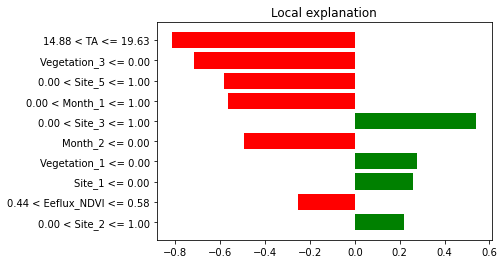

In [10]:
exp = explainer.explain_instance(X_test.iloc[0], 
     ngb_exp.predict, num_features=10)
exp.as_pyplot_figure()

Interpret a random record

In [10]:
i = 3
exp = explainer.explain_instance(np.array(X_test)[i], ngb_exp.predict, num_features=10)

Intercept 3.183292742074774
Prediction_local [5.20327395]
Right: 1.740203467489894


In [11]:
Y_test.iloc[i]

LE_bowen_corr_mm    2.48624
Name: 3, dtype: float64

In [12]:
exp.show_in_notebook(show_table=True, show_all = False)

In [14]:
exp.as_list()

[('14.88 < TA <= 19.63', -0.8008364504247454),
 ('Vegetation_3 <= 0.00', -0.6847281784610542),
 ('0.00 < Month_1 <= 1.00', -0.5578845948700359),
 ('0.00 < Site_3 <= 1.00', 0.546332852338659),
 ('0.00 < Site_5 <= 1.00', -0.5238896467798715),
 ('Vegetation_1 <= 0.00', 0.5150478015152608),
 ('Month_2 <= 0.00', -0.4354717363385768),
 ('Eeflux_NDVI-2 <= 0.44', -0.29291896143509344),
 ('Site_1 <= 0.00', 0.2663630429008062),
 ('0.44 < Eeflux_NDVI <= 0.58', -0.2639470254746194)]

In [17]:
i = 29
exp_accurate = explainer.explain_instance(np.array(X_test_accurate)[i], ngb_exp.predict, num_features=49)

Intercept 5.152770547207143
Prediction_local [0.58259824]
Right: 1.6040681118822355


In [14]:
exp_accurate.show_in_notebook(show_table=True)